# Initialization
## Import Libraries

In [1]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-12 08:38:30.480880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752309510.850369      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752309510.953143      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ℹ️ Set Global Constants

In [2]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/precis-har-rgb"
DATASET_NAME = DATASET_DIR.split("/")[-1].replace("-", " ").title()

print(DATASET_NAME)

ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = len(ALL_CLASS_NAMES)
CLASSES_LIST = ALL_CLASS_NAMES[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 5

# set drop out rate
DROPOUT_RATE = 0.5

# set datas
MAX_VIDEO_PER_CLASS = None

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 30
BATCH_SIZE = 24
VALIDATION_SPLIT = 0.20

# augmentation values
NOISE_FACTOR = 0.02
SHEAR_X= 1
SHEAR_Y= 1

# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

Precis Har Rgb
There are total 16 classes, selected 16 classes
Setting None/class to train the model.
Image size 128x128 with 5 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


## Set `Seed` Values

In [3]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 📌 Function Definition
## Resize and Frame Extraction

In [4]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.metrics import structural_similarity as ssim

# Placeholder for kmeans_silhouette function
def kmeans_silhouette(sub_features):
    if len(sub_features) < 2:
        return [], [], 1, [0]  # Return empty results for insufficient frames
    
    # Try different k values (2 to min(5, len(sub_features)))
    best_k = 2
    best_labels = None
    best_centers = None
    best_score = -1
    best_indices = []
    
    for k in range(2, min(6, len(sub_features) + 1)):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(sub_features)
        if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(sub_features, labels)
            if score > best_score:
                best_score = score
                best_k = k
                best_labels = labels
                best_centers = kmeans.cluster_centers_
        
        # Find indices of frames closest to cluster centers
        indices = []
        for i in range(best_k):
            if i in labels:
                cluster_points = sub_features[labels == i]
                distances = np.linalg.norm(cluster_points - best_centers[i], axis=1)
                if len(distances) > 0:
                    idx = np.argmin(distances)
                    indices.append(idx)
    
    return best_labels, best_centers, best_k, indices

# Placeholder for redundancy function
def redundancy(video_path, indices, threshold=0.94):
    if not indices:
        return []
    
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        return indices
    
    # Compute histogram for each frame
    def get_histogram(frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        return hist
    
    filtered_indices = [indices[0]]  # Keep first index
    prev_frame = None
    
    for idx in indices[1:]:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success:
            continue
        hist = get_histogram(frame)
        
        if prev_frame is not None:
            # Compute histogram correlation
            corr = cv2.compareHist(get_histogram(prev_frame), hist, cv2.HISTCMP_CORREL)
            if corr < threshold:  # Keep frame if significantly different
                filtered_indices.append(idx)
        prev_frame = frame
    
    video_reader.release()
    return filtered_indices

# Modified scen_keyframe_extraction function
def frames_extraction(video_path,  file_name, video_index, is_last_video, num_segments=SEQUENCE_LENGTH):
    # Open video to get frame count
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        raise ValueError(f"Failed to open video {video_path}.")
    
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        video_reader.release()
        raise ValueError(f"No frames in video {video_path}.")
    
    # Generate synthetic scene segmentation (divide video into equal segments)
    segment_length = frame_count // num_segments
    number_list = []
    for i in range(num_segments):
        start = i * segment_length
        end = min((i + 1) * segment_length, frame_count)
        number_list.extend([start, end])

    features = []
    frame_idx = 0
    
    while True:
        success, frame = video_reader.read()
        if not success:
            break
    
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        features.append(hist.flatten())
        
        frame_idx += 1
    
    video_reader.release()
    features = np.asarray(features)
    
    # Clustering at each shot to obtain keyframe sequence numbers
    keyframe_index = []
    for i in range(0, len(number_list), 2):
        start = number_list[i]
        end = min(number_list[i + 1], len(features))
        if end <= start:
            continue
        sub_features = features[start:end]
        best_labels, best_centers, k, indices = kmeans_silhouette(sub_features)
        final_index = [x + start for x in indices if x + start < frame_count]
        final_index = redundancy(video_path, final_index, 0.94)
        keyframe_index += final_index
    
    keyframe_index = sorted(list(set(keyframe_index)))  # Remove duplicates and sort
    # print("final_index:", keyframe_index, end="\r", flush=True)
    
    # Visualize keyframes
    num_keyframes = len(keyframe_index)
    if num_keyframes == 0:
        print("No keyframes extracted.")
        return
    
    video_reader = cv2.VideoCapture(video_path)
    class_name = os.path.basename(os.path.dirname(video_path))
    # print(keyframe_index)
    frames=[]
    frames_index=[]
    for idx, frame_idx in enumerate(keyframe_index, 1):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video_reader.read()
        if not success:
            continue
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        try:
            resized_frame = cv2.resize(rgb_frame, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_AREA)
            normalized_frame = resized_frame.astype('float32') / 255.0

            
            if normalized_frame.shape != (IMAGE_HEIGHT, IMAGE_WIDTH, 3):
                print(f"Warning: Frame at index {frame_idx} has incorrect shape: {normalized_frame.shape}")
                continue  # Skip malformed frame
            if is_last_video and idx == num_keyframes:
                print(f"Extracted {len(frames)+1} frames from file {video_index+1}: {file_name}", end="\n", flush=True)
            else:
                print(f"Extracted {len(frames)+1} frames from file {video_index+1}: {file_name}", end="\r", flush=True)
                
            frames.append(normalized_frame)
            frames_index.append(frame_idx)
        
        except Exception as e:
            print(f"Error processing frame {frame_idx}: {e}")
            continue
    video_reader.release()

    # handle inhomogenous frames or shape mismatch
    if len(frames) > SEQUENCE_LENGTH:
        # if it is greater than sequence length then leave the last frames
        frames=frames[:SEQUENCE_LENGTH]
    
    frames=np.asarray(frames)
    frames_index=np.asarray(frames_index)
    return frames, frames_index

    
# # Run the keyframe extraction
# sequence, index = scen_keyframe_extraction(video_path, num_segments=5)

# print(sequence.shape)

# show_frames(sequence, index)

## Create Dataset

In [5]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    videos = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        is_last_video=False
        for (index, file_name) in enumerate(files_list):
            video_file_path = os.path.join(class_path, file_name)

            if index == (len(files_list)-1):
                is_last_video=True
                # print(f'Extracting frames from file {index+1}: {file_name}', flush=True)
            else:
                is_last_video=False
                # print(f'Extracting frames from file {index+1}: {file_name}', end="\r", flush=True)
            
            # Extract frames using the updated frames_extraction function
            # frames = frames_extraction(video_file_path, 
            #                            sequence_length, 
            #                            image_height, 
            #                            image_width)
            frames, index = frames_extraction(video_path=video_file_path, 
                                                     file_name=file_name,
                                                     video_index=index,
                                                     is_last_video=is_last_video,
                                                     num_segments=SEQUENCE_LENGTH)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            videos.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not videos:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    videos = np.asarray(videos)
    labels = np.array(labels)

    print(f"Dataset created with {len(videos)} videos")
    print(f"Features shape: {videos.shape}")
    print(f"Labels shape: {labels.shape}")

    return videos, labels

## 🪄 Video Data Generator

In [6]:
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import numpy as np
import cv2




class VideoDataGenerator(Sequence):
    def __init__(self, videos, labels, batch_size, is_training=False):
        self.videos = list(videos)  # List of video file paths
        self.labels = list(labels)  # List or array of labels encoded
        self.batch_size = batch_size
        self.indices = np.arange(len(self.videos))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied
        self.temp_videos=[]
        self.temp_labels=[]
        
        
        print(f"Total {len(videos)} videos and {len(labels)} classes")

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.videos) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each video in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.videos[index]
            label = self.labels[index]
            
            # Load and process video
            # sequence = frames_extraction(video_path)

            # if sequence is not None:
            #     # Apply augmentations: 1 original + 4 augmentations (horizontal flip, shear, rotation, noise)
            #     augmented_sequences = [sequence]  # Add original sequence

            #     if self.is_training:
            #         # Apply augmentations
            #         augmented_sequences.append(np.array(horizontal_flip(sequence)))  # Horizontal Flip
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=0)))  # Random Shear
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=1)))  # Random Rotation
            #         augmented_sequences.append(np.array(noise_video(sequence)))  # Salt and Pepper Noise

            #     # Add augmented sequences to the batch
            #     all_frames.extend(augmented_sequences)
            #     all_labels.extend([label] * len(augmented_sequences))  # Each augmentation has the same label

            
            # Append the sequence and label
            all_frames.append(sequence)
            all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        all_labels = np.array(all_labels)
            
        
        return all_frames, all_labels
    def add(self, new_videos, new_labels):
        self.temp_videos.extend(new_videos)
        self.temp_labels.extend(new_labels)
    
    def confirm(self):
        print(f"Adding {len(self.temp_videos)} videos with {len(self.temp_labels)} classes.")
        self.videos.extend(self.temp_videos)
        self.labels.extend(self.temp_labels)
        print(f"Successfully added - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        self.temp_videos=[]
        self.temp_labels=[]
        self.indices = np.arange(len(self.videos))
        print(f"Now Total - {len(self.videos)} videos and {len(self.labels)} classes.")
        print(f"PENDING for Augmentations - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
    
    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
        self.labels=np.array(self.labels)
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                (None, NO_OF_CLASSES)
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

## Debug and Helpers

## 💫 Augmentation Helper function

In [7]:
import time

    

def apply_augmentation(augmentation_function, generator, confirm=False, *args, **kwargs):
    
    for i in range(len(generator)):
        batch_videos, batch_labels = generator[i]
        augmented_videos=[]
        for videos in batch_videos:
            augmented_videos.append(augmentation_function(videos, *args, **kwargs))
        generator.add(augmented_videos, batch_labels)
        print(f"Processing video {len(generator.temp_videos)}...", end="\r", flush=True)
        time.sleep(0.5)  # simulate work
    if confirm:
        generator.confirm()

### Show Frames

In [8]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

### Helper Function

In [9]:
def show_frame_vs(frame1, frame2, title1="Frame 1", title2="Frame 2"):
    plt.figure(figsize=(10, 5))

    # First frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame1)
    plt.title(title1)
    plt.axis('off')

    # Second frame
    plt.subplot(1, 2, 2)
    plt.imshow(frame2)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
# reusable video loop helper function
def apply_function(function, videos, *arg, **kwargs):
    new_videos=[]
    
    for video in videos:
        new_videos.append(function(video, *arg, **kwargs))
        
    return new_videos

In [11]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

## Salt and Pepper Noise 

In [12]:
# Noise function def

def noise_video(video,noise_factor=NOISE_FACTOR):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

## Horizontal Flip

In [13]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

## Random Shear

In [14]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = 0.1
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

# 📌 Model Related
## 🗼 Model Architecture `create_model`

In [15]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, TimeDistributed, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_xception_lstm_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5):
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")

    try:
        # Load Xception model with pre-trained ImageNet weights
        print("Loading Xception base model...")
        xception = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(image_height, image_width, 3),
            name="Xception"
        )
        # Freeze Xception layers
        for layer in xception.layers[:-10]:  # Unfreeze last 10 layers
            layer.trainable = False
        for layer in xception.layers[-10:]:
            layer.trainable = True

        # Define the Sequential model
        model = Sequential([
            # InputLayer and TimeDistributed Xception
            TimeDistributed(
                xception,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_1"),
            # LSTM layer with 128 units
            LSTM(128, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm"),
            
            BatchNormalization(name="batch_normalization"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense"),
            # Dropout after Dense
            Dropout(dropout_rate + 0.1, name="dropout_dense"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="dense_1")
        ])
        
        # Print model summary
        print("Model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        return None

In [16]:
# donwload model weights
from tensorflow.keras.applications import Xception
print("Pre-loading Xception weights...")
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print("Weights loaded successfully!")

Pre-loading Xception weights...


I0000 00:00:1752309532.201509      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752309532.202317      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!


# 📌 Execution
## Creating Dataset
The following functions are executed
- `frame extraction`
- `resize`

which returns:
- `features` - `np.array` of all the videos
- `labels` - `np.array` of all the class labels

In [17]:
# RUN Create the dataset with explicit parameters
try:
    videos, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

videos.shape, labels.shape

Extracting Data of Class: write
Extracted 5 frames from file 50: subject_42_activity_5.mp4
Extracting Data of Class: sit still
Extracted 5 frames from file 50: subject_35_activity_3.mp4
Extracting Data of Class: sit down
Extracted 5 frames from file 50: subject_12_activity_2.mp4
Extracting Data of Class: move hands in front of the body
Extracted 5 frames from file 50: subject_38_activity_11.mp4
Extracting Data of Class: raise one leg up
Extracted 5 frames from file 50: subject_10_activity_14.mp4
Extracting Data of Class: drink from a bottle
Extracted 5 frames from file 50: subject_38_activity_9.mp4
Extracting Data of Class: stand up
Extracted 5 frames from file 50: subject_47_activity_1.mp4
Extracting Data of Class: read
Extracted 5 frames from file 50: subject_16_activity_4.mp4
Extracting Data of Class: throw paper
Extracted 5 frames from file 50: subject_15_activity_8.mp4
Extracting Data of Class: walk
Extracted 5 frames from file 50: subject_13_activity_7.mp4
Extracting Data of Clas

((800, 5, 128, 128, 3), (800,))

In [18]:
video_generator = VideoDataGenerator(
    videos=videos,
    labels=labels,
    batch_size=BATCH_SIZE
)

Total 800 videos and 800 classes


In [19]:
videos, labels = video_generator[3]

videos.shape, labels.shape

((24, 5, 128, 128, 3), (24,))

In [20]:
len(video_generator.videos) 

800

In [21]:
len(video_generator)

34

## Apply ***horizontal flip*** (Augmentation)

In [22]:
apply_augmentation(horizontal_flip, video_generator)

In [23]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 800, 800
PENDING Total Videos and Class Count: 800, 800


In [24]:
video_generator.confirm()

Adding 800 videos with 800 classes.
Successfully added - 800 videos and 800 classes.
Now Total - 1600 videos and 1600 classes.
PENDING for Augmentations - 0 videos and 0 classes.


## Apply ***Noise*** (Augmentation)

In [25]:
apply_augmentation(noise_video, video_generator)

In [26]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 1600, 1600
PENDING Total Videos and Class Count: 1600, 1600


## Apply ***Random Shear x2*** (Augmentation)

In [27]:
apply_augmentation(apply_shear_frames, video_generator, shear_right=0)
apply_augmentation(apply_shear_frames, video_generator, shear_right=1)

In [28]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 1600, 1600
PENDING Total Videos and Class Count: 4800, 4800


In [29]:
# confirm changes to generator
video_generator.confirm()

Adding 4800 videos with 4800 classes.
Successfully added - 4800 videos and 4800 classes.
Now Total - 6400 videos and 6400 classes.
PENDING for Augmentations - 0 videos and 0 classes.


In [30]:
print(f"Checking Video Generator Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")

Checking Video Generator Total Videos and Class Count: 6400, 6400


## Cheking (Output)

(24, 5, 128, 128, 3) (24,)


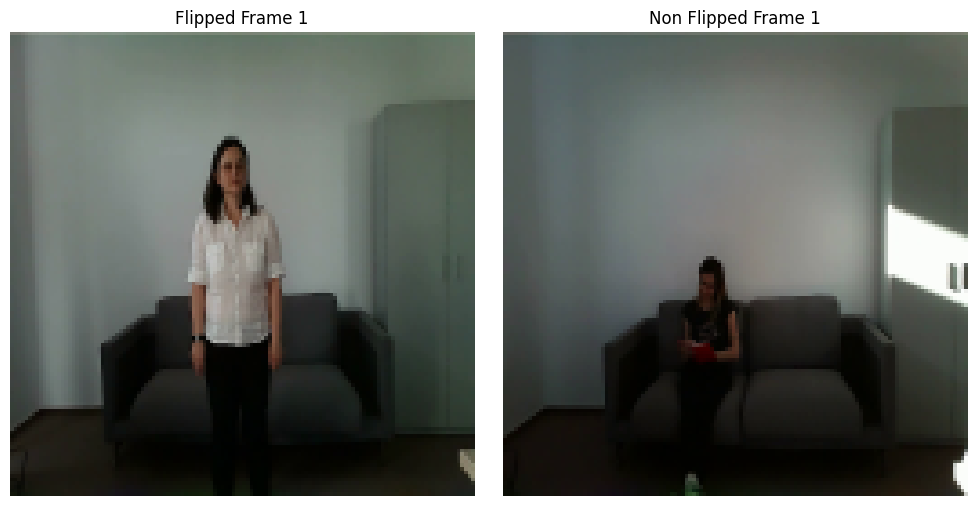

Might be two different action, but to check the flipping focus on the door behind.


In [31]:
# check horizontal flips
videos, labels = video_generator[7]
videos1, labels1 = video_generator[1]

print(videos.shape, labels.shape)

show_frame_vs(videos[0,0],videos1[1,0], title1="Flipped Frame 1", title2="Non Flipped Frame 1")
print("Might be two different action, but to check the flipping focus on the door behind.")

# 🧪 Test Augmentation (Output)
## 🖼️ Horizontal Flip Output

In [32]:
# flipped_video_1 = horizontal_flip(features[0])

# flipped_video_1=np.asarray(flipped_video_1)

# show_frame(flipped_video_1[0])
# flipped_video_1.shape

## 🖼️ Salt and Pepper Noise Output

In [33]:
# noised_video = noise_video(features[0])

# print(noised_video.shape)
# show_frame(noised_video[0])

## 🖼️ Random Shear Output

In [34]:
# print(features.shape)

# sheared_1 = apply_shear_frames(features[0], shear_right=0)
# sheared_2 = apply_shear_frames(features[0], shear_right=1)

# sheared_1 = np.asarray(sheared_1)
# sheared_2 = np.asarray(sheared_2)

# print(sheared_1.shape)
# show_frame(sheared_1[0])
# show_frame(sheared_2[0])

# 📌 Preparing Data for Training

In [35]:
# Clear previous session to free memory
import gc

gc.collect()
tf.keras.backend.clear_session()

## Splitting data for ***Trainig*** and ***Testing***

In [36]:
videos = video_generator.videos
labels = video_generator.labels

videos = np.array(videos, dtype='float32')
labels = np.array(labels)

videos.shape, labels.shape

((6400, 5, 128, 128, 3), (6400,))

In [37]:
from tensorflow.keras.utils import to_categorical

one_hot_encoded_labels = to_categorical(labels)

one_hot_encoded_labels.shape

(6400, 16)

In [38]:
gc.collect()

0

In [39]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(videos,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((5120, 5, 128, 128, 3), (5120, 16), (1280, 5, 128, 128, 3), (1280, 16))

## Splitting data for ***Training Set*** and ***Validation Set***

In [40]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, train_labels.shape, val_video_frames.shape, val_labels.shape

((4096, 5, 128, 128, 3), (4096, 16), (1024, 5, 128, 128, 3), (1024, 16))

## Use Generator `Video Data Generator`

In [41]:
# Create the training and validation generators
train_gen = VideoDataGenerator(
    videos=train_video_frames, 
    labels=train_labels, 
    batch_size=BATCH_SIZE,
)

val_gen = VideoDataGenerator(
    videos=val_video_frames, 
    labels=val_labels, 
    batch_size=BATCH_SIZE,
)

len(train_gen), len(val_gen)

Total 4096 videos and 4096 classes
Total 1024 videos and 1024 classes


(171, 43)

## Inspect ***Generator*** Data on Epochs

In [42]:
features, labels = train_gen[1]

print(train_gen.indices)

train_gen.on_epoch_end()

print(train_gen.indices)

BATCH_SIZE, features.shape, labels.shape

[   0    1    2 ... 4093 4094 4095]
[1355  207 1540 ...  885 3068 2783]


(24, (24, 5, 128, 128, 3), (24, 16))

## Compute Class Weight

In [43]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_int are integer labels (not one-hot)
y_int = np.argmax(one_hot_encoded_labels, axis=1)  # or just integer labels if you have them

classes = np.arange(NO_OF_CLASSES)  # e.g. np.arange(16)
class_weights_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_int)

class_weights = dict(zip(classes, class_weights_values))

print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0}


In [44]:
gc.collect()
del videos, one_hot_encoded_labels, labels_train
del features_train, val_labels, train_labels
del val_video_frames, train_video_frames

# ✨ Model Execution
## Creating Model

In [45]:
# Create the model
xlstm_model = create_xception_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE
)

# Check if model was created successfully
if xlstm_model is None:
    print("Failed to create model. Check error messages above.")
else:
    print("Model Created Successfully!")

Loading Xception base model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 4, 4, 2048)  │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,050,872 (84.12 MB)

 Trainable params: 6,685,456 (25.50 MB)

 Non-trainable params: 15,365,416 (58.61 MB)

Model Created Successfully!


## Plot Model Structure

In [46]:
# Plot the structure of the contructed model.
from tensorflow.keras.utils import plot_model

plot_model(xlstm_model, to_file = f'{MODEL_NAME}_model_Plot.png', show_shapes = True, show_layer_names = True)

print(f"{MODEL_NAME} Model Plot saved successfully...")

Xception Model Plot saved successfully...


## Model Compile

In [47]:
# Create an Instance of Early Stopping Callback
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 7, 
                                        mode = 'min', 
                                        restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
xlstm_model.compile(loss = 'categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics = ["accuracy"])


## 💪 Model Fit

In [48]:
labels = np.argmax(train_gen.labels, axis=1)  # assuming one-hot encoded
print("Unique labels:", np.unique(labels))
print("NO_OF_CLASSES:", NO_OF_CLASSES)


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
NO_OF_CLASSES: 16


In [49]:
print("Train label shape:", np.shape(train_gen.labels))
print("Val label shape:", np.shape(val_gen.labels))


Train label shape: (4096, 16)
Val label shape: (1024, 16)


In [50]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
#                                  factor=0.5, 
#                                  patience=3, 
#                                  min_lr=1e-6)



# print(f"Dataset - {DATASET_NAME}")
# print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
# print(f"Setting {MAX_VIDEO_PER_CLASS} videos/class to train the model.")
# print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
# print(f"Dropout rate: {DROPOUT_RATE}")
# print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
# print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

# print("\n")

# print(f"Training started for {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")

# model_history = xlstm_model.fit(
#     train_gen.as_dataset(),
#     validation_data=val_gen.as_dataset(),
#     epochs=EPOCHS,
#     # class_weight=class_weight_dict,
#     callbacks=[early_stopping_callback, lr_scheduler]
# )

# Evaluation

## ⚡ Model Evaluate

In [51]:
# # previous code
# model_evaluation_history = xlstm_model.evaluate(features_test, labels_test)

In [52]:
# import matplotlib.pyplot as plt

# # Accuracy
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(model_history.history['accuracy'], label='Train Accuracy')
# plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Loss
# plt.subplot(1, 2, 2)
# plt.plot(model_history.history['loss'], label='Train Loss')
# plt.plot(model_history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()


## 📈 Confusion Matrix

In [53]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create test generator with batch_size matching test set size
# test_gen = VideoDataGenerator(
#     videos=features_test,
#     labels=labels_test,
#     batch_size=4,  # Process all test samples at once
# )

# # Get predictions
# predictions = xlstm_model.predict(test_gen.as_dataset())
# predicted_classes = np.argmax(predictions, axis=1)
# true_classes = np.argmax(labels_test, axis=1)

# # Verify shapes
# print(f"True classes shape: {true_classes.shape}")
# print(f"Predicted classes shape: {predicted_classes.shape}")
# assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

# # Generate classification report
# print("Classification Report:")
# print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

# # Plot confusion matrix
# cm = confusion_matrix(true_classes, predicted_classes)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST[-1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 512)   │    20,024,384 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 512)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,931,728 (83.66 MB)

 Trainable params: 1,906,320 (7.27 MB)

 Non-trainable params: 20,025,408 (76.39 MB)

VGG19+LSTM Model Created Successfully!
Xception_VGG19_LSTM Model Plot saved successfully...
train_gen.videos shape: (4096, 5, 128, 128, 3)
train_gen.labels shape: (4096, 16)
val_gen.videos shape: (1024, 5, 128, 128, 3)
val_gen.labels shape: (1024, 16)
features_test shape: (1280, 5, 128, 128, 3)
labels_test shape: (1280, 16)
train_gen batch videos shape: (24, 5, 128, 128, 3)
train_gen batch labels shape: (24, 16)
val_gen batch videos shape: (24, 5, 128, 128, 3)
val_gen batch labels shape: (24, 16)
Dataset - Precis Har Rgb
There are total 16 classes, selected 16 classes
Setting None videos/class to train the model.
Image size 128x128 with 5 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


Initial training started for VGG19+LSTM model with 4096 videos of 16 classes with 1024 videos for validation...
Epoch 1/30


I0000 00:00:1752312028.989516      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


    171/Unknown 61s 271ms/step - accuracy: 0.2006 - loss: 16.0335

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step - accuracy: 0.2010 - loss: 16.0092 - val_accuracy: 0.1992 - val_loss: 7.7849 - learning_rate: 0.0010
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - accuracy: 0.4318 - loss: 5.9107 - val_accuracy: 0.4648 - val_loss: 4.3850 - learning_rate: 0.0010
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - accuracy: 0.5264 - loss: 3.3627 - val_accuracy: 0.2832 - val_loss: 3.4515 - learning_rate: 0.0010
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 321ms/step - accuracy: 0.5673 - loss: 2.3400 - val_accuracy: 0.3545 - val_loss: 2.8855 - learning_rate: 0.0010
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 321ms/step - accuracy: 0.6084 - loss: 1.8780 - val_accuracy: 0.2910 - val_loss: 3.5120 - learning_rate: 0.0010
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 319ms/step - accuracy: 0.6308 - loss: 1.6515 - val_accuracy: 0.3740 - val_loss: 2.7979 - learning_rate: 0.0010
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 55s 321ms/step - accuracy: 0.6542 - loss

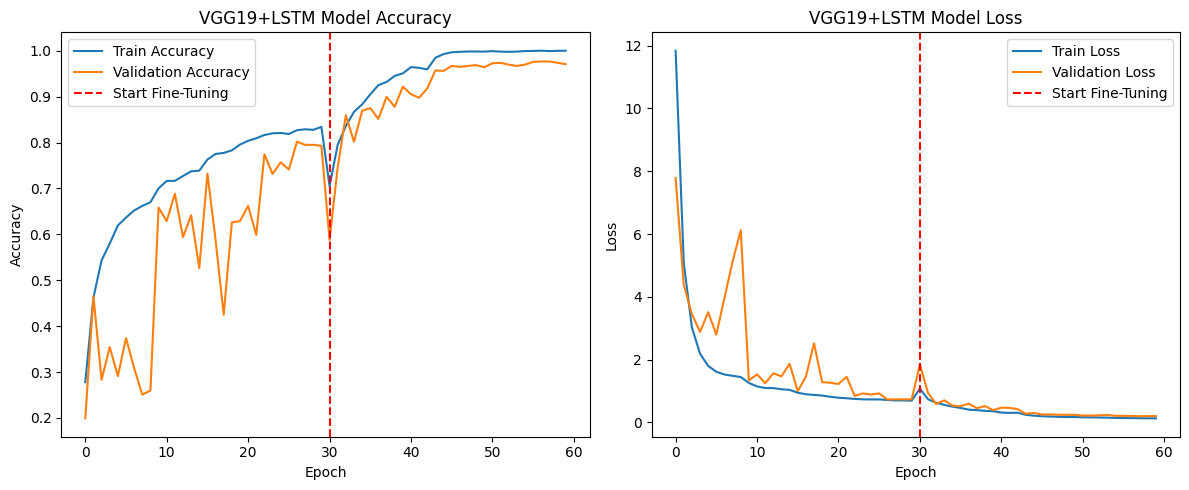

54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step
True classes shape: (1280,)
Predicted classes shape: (1280,)

VGG19+LSTM Classification Report:
                                 precision    recall  f1-score   support

                          write       0.88      0.88      0.88        82
                      sit still       0.94      0.96      0.95        76
                       sit down       1.00      1.00      1.00        84
move hands in front of the body       0.96      1.00      0.98        80
               raise one leg up       0.99      1.00      0.99        78
            drink from a bottle       0.91      0.95      0.93        79
                       stand up       1.00      1.00      1.00        83
                           read       0.88      0.88      0.88        81
                    throw paper       1.00      0.98      0.99        81
                           walk       1.00      1.00      1.00        74
               drink from a mug       0.97      0.93      

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


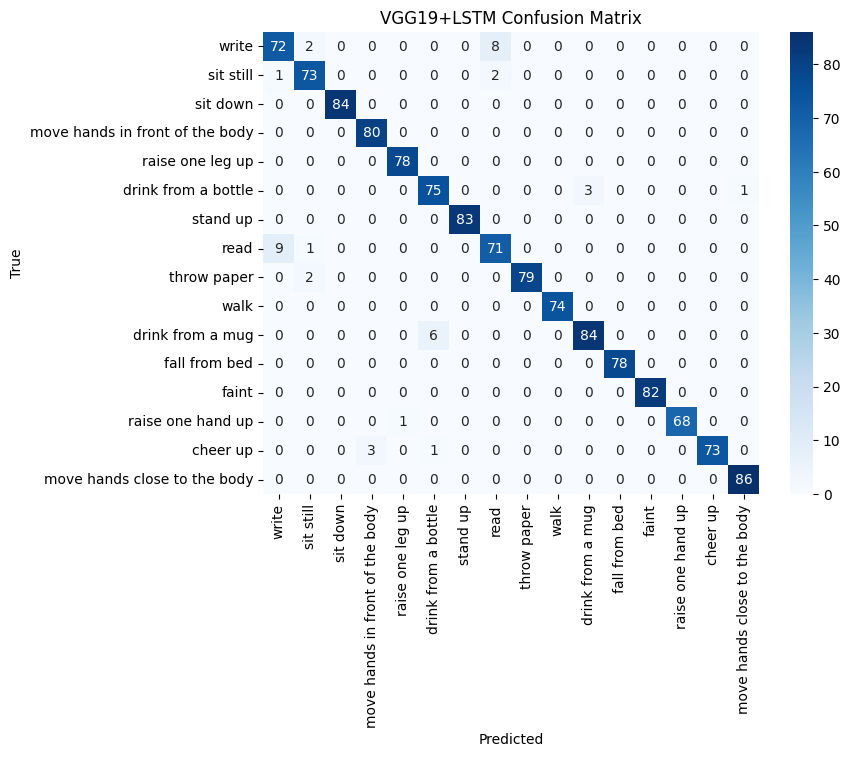

In [54]:
# Import necessary libraries
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import gc

# Clear memory before creating the new model
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")
    print("Falling back to initializing VGG19 without pre-trained weights...")
    base_model = VGG19(weights=None, include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Define function to create VGG19+LSTM model
def create_vgg19_lstm_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        vgg19 = base_model
        # Freeze the base model for initial training
        vgg19.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                vgg19,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            Bidirectional(LSTM(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19")),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Create the VGG19+LSTM model using the pre-loaded base model
vgg19_lstm_model = create_vgg19_lstm_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if model was created successfully
if vgg19_lstm_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Plot the model structure
from tensorflow.keras.utils import plot_model
try:
    plot_model(vgg19_lstm_model, to_file=f'{MODEL_NAME}_VGG19_LSTM_model_Plot.png', show_shapes=True, show_layer_names=True)
    print(f"{MODEL_NAME}_VGG19_LSTM Model Plot saved successfully...")
except Exception as e:
    print(f"Failed to plot model: {str(e)}")

# Verify data shapes
print(f"train_gen.videos shape: {np.shape(train_gen.videos)}")
print(f"train_gen.labels shape: {np.shape(train_gen.labels)}")
print(f"val_gen.videos shape: {np.shape(val_gen.videos)}")
print(f"val_gen.labels shape: {np.shape(val_gen.labels)}")
print(f"features_test shape: {np.shape(features_test)}")
print(f"labels_test shape: {np.shape(labels_test)}")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Verify generator batch shapes
try:
    videos, labels = train_gen[0]
    print(f"train_gen batch videos shape: {videos.shape}")
    print(f"train_gen batch labels shape: {labels.shape}")
    videos, labels = val_gen[0]
    print(f"val_gen batch videos shape: {videos.shape}")
    print(f"val_gen batch labels shape: {labels.shape}")
except Exception as e:
    print(f"Error accessing generator data: {str(e)}")

# Compile the model for initial training
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

vgg19_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Print dataset summary
print(f"Dataset - {DATASET_NAME}")
print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS} videos/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")
print("\n")

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    vgg19_history_initial = vgg19_lstm_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[early_stopping_callback, lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
vgg19_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    vgg19_history_fine = vgg19_lstm_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[early_stopping_callback, lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()

# Evaluate the model on the test set
print("\nEvaluating VGG19+LSTM model on test set...")
test_gen = VideoDataGenerator(
    videos=features_test,
    labels=labels_test,
    batch_size=BATCH_SIZE
)
try:
    videos, labels = test_gen[0]
    print(f"test_gen batch videos shape: {videos.shape}")
    print(f"test_gen batch labels shape: {labels.shape}")
    loss, accuracy = vgg19_lstm_model.evaluate(test_gen.as_dataset())
    print(f'VGG19+LSTM Test Loss: {loss:.4f}')
    print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')
except Exception as e:
    print(f"Error during model evaluation: {str(e)}")
    import traceback
    traceback.print_exc()

# Plot training history (combine initial and fine-tuning)
import matplotlib.pyplot as plt

try:
    # Combine histories
    history_accuracy = vgg19_history_initial.history['accuracy'] + vgg19_history_fine.history['accuracy']
    history_val_accuracy = vgg19_history_initial.history['val_accuracy'] + vgg19_history_fine.history['val_accuracy']
    history_loss = vgg19_history_initial.history['loss'] + vgg19_history_fine.history['loss']
    history_val_loss = vgg19_history_initial.history['val_loss'] + vgg19_history_fine.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_accuracy, label='Train Accuracy')
    plt.plot(history_val_accuracy, label='Validation Accuracy')
    plt.axvline(x=len(vgg19_history_initial.history['accuracy']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title('VGG19+LSTM Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_loss, label='Train Loss')
    plt.plot(history_val_loss, label='Validation Loss')
    plt.axvline(x=len(vgg19_history_initial.history['loss']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title('VGG19+LSTM Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error plotting training history: {str(e)}")

# Generate confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
try:
    predictions = vgg19_lstm_model.predict(test_gen.as_dataset())
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)

    # Verify shapes
    print(f"True classes shape: {true_classes.shape}")
    print(f"Predicted classes shape: {predicted_classes.shape}")
    assert len(true_classes) == len(predicted_classes), "Sample counts do not match!"

    # Generate classification report
    print("\nVGG19+LSTM Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=CLASSES_LIST))

    # Plot confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('VGG19+LSTM Confusion Matrix')
    plt.show()
except Exception as e:
    print(f"Error during prediction or plotting: {str(e)}")
    import traceback
    traceback.print_exc()

In [55]:
# previous code
model_evaluation_history = vgg19_lstm_model.evaluate(features_test, labels_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - accuracy: 0.9620 - loss: 0.2238
